In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
!qselect -N dask-worker | xargs qdel

usage:
	qdel [-W force|suppress_email=X] [-x] job_identifier...
	qdel --version


In [3]:
import numpy
import xarray
import matplotlib.pyplot as mp
import glob
import pandas
import cartopy
import itertools
import dask_jobqueue
#import tqdm

%matplotlib inline

In [73]:
cluster = dask_jobqueue.PBSCluster(processes=18,
                                   memory='10 GB',
                                   #cores=1,
                                   project='UCLA0022',
                                   queue='regular',
                                   resource_spec='select=1:ncpus=36:mem=109G',
                                   walltime='00:01:00')
cluster.start_workers(10)

from dask.distributed import Client
client = Client(cluster)

In [74]:
!qdel 3446015

qdel: Job has finished


In [75]:
!qstat -u baird


chadmin1: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
3446055.chadmin baird    regular  dask-worke    --    1  36  109gb 00:01 Q   -- 
3446059.chadmin baird    regular  dask-worke    --    1  36  109gb 00:01 Q   -- 
3446060.chadmin baird    regular  dask-worke    --   10 360 1090gb 00:01 Q   -- 


In [2]:
#PRECT_root = '/ninad/NCAR_LENS/PRECT/'
#PRECT_root = '/scratch/blangenb/NCAR_LENS/PRECT/'
PRECT_root =  '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PRECT/'

In [3]:
# lon_qtr = int(288/4)
# lat_qtr = int(192/4)
# lon_half = int(288/2)
# lat_half = int(192/2)

lon_size = 288
lat_size = 192

In [4]:
# lon_divisions = [i for i in range(0,lonsize+1,int(lonsize/4))]
# lat_divisions = [i for i in range(0,latsize+1,int(latsize/4))]
lon_divisions = [i for i in range(0,lon_size+1,48)]
lat_divisions = [i for i in range(0,lat_size+1,48)]

In [5]:
lon_divisions

[0, 48, 96, 144, 192, 240, 288]

In [6]:
lat_divisions

[0, 48, 96, 144, 192]

In [7]:
ll_corners = list(itertools.product(lon_divisions[:-1],lat_divisions[:-1]))
ur_corners = list(itertools.product(lon_divisions[1:],lat_divisions[1:]))

In [8]:
for i,val in enumerate(ll_corners):
    print(val[0],val[1],'to',ur_corners[i][0],ur_corners[i][1])
    
#i=0
#ll_corners[i][0],ur_corners[i][0]

0 0 to 48 48
0 48 to 48 96
0 96 to 48 144
0 144 to 48 192
48 0 to 96 48
48 48 to 96 96
48 96 to 96 144
48 144 to 96 192
96 0 to 144 48
96 48 to 144 96
96 96 to 144 144
96 144 to 144 192
144 0 to 192 48
144 48 to 192 96
144 96 to 192 144
144 144 to 192 192
192 0 to 240 48
192 48 to 240 96
192 96 to 240 144
192 144 to 240 192
240 0 to 288 48
240 48 to 288 96
240 96 to 288 144
240 144 to 288 192


Open pre-industrial control as multi-file dataset

In [9]:
example_pic_mfds = xarray.open_mfdataset(PRECT_root + 'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.0402*')
lat_total = example_pic_mfds['lat']
lon_total = example_pic_mfds['lon']

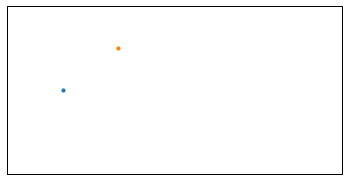

In [10]:
i = 5
fig = mp.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())

#ax.coastlines()

for i in [range(ll_corners.__len__())[18]]:

    lat_lo = ll_corners[i][1]
    lat_hi = ur_corners[i][1]
    lon_lo = ll_corners[i][0]
    lon_hi = ur_corners[i][0]
    
    ax.scatter(lon_total[lon_lo],lat_total[lat_lo], transform=cartopy.crs.PlateCarree(), zorder=10, s=10)
    ax.scatter(lon_total[lon_hi-1],lat_total[lat_hi-1], transform=cartopy.crs.PlateCarree(), zorder=10, s=10)
    
ax.set_global()

In [11]:
# prect_pic_mfds = xarray.open_mfdataset(PRECT_root + 'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.*.nc', \
#                                       chunks={'lat':12, 'lon':12}).isel(lat=slice(0,lat_qtr), lon=slice(0,lon_qtr))
# prect_pic_mfds = xarray.open_mfdataset(PRECT_root + 'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.*.nc', \
#                                        chunks={'lat':12, 'lon':12}).isel(lat=slice(0,lat_half), lon=slice(0,lon_half))
# prect_pic_mfds = xarray.open_mfdataset(PRECT_root + 'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.*.nc').isel(lat=slice(0,5), lon=slice(0,5))

i = 18
prect_pic_mfds = xarray.open_mfdataset(PRECT_root + 'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.*.nc').isel(\
                                        lat=slice(ll_corners[i][1],ur_corners[i][1]), lon=slice(ll_corners[i][0],ur_corners[i][0]))

In [12]:
prect_pic = prect_pic_mfds['PRECT']*86400.*1000.
lon = prect_pic_mfds['lon']
lat = prect_pic_mfds['lat']
time = prect_pic_mfds['time'].values

for checking memory usage

get dates corresponding to ONDJFM

In [13]:
time_datetime = numpy.copy(time) #pandas.to_datetime(time)
time_seas_indices = [d.month in [10,11,12,1,2,3] for d in time_datetime]

step below takes about 15 MINUTES

In [14]:
prect_pic_data = prect_pic.values

set all <0.1 equal to zero (~15 seconds)

In [15]:
prect_pic_data[prect_pic_data<0.1] = 0

take rolling mean (~3 minutes)

In [16]:
window_size = 30
prect_pic_data_rolling30 = numpy.zeros((prect_pic.shape))
for j in range(lat.size):
    for k in range(lon.size):
        prect_pic_data_rolling30[:,j,k] = pandas.Series(prect_pic_data[:,j,k]).rolling(window=window_size).sum()

begin seasonal analysis

In [ ]:
prect_pic_seas_data = prect_pic_data[time_seas_indices,:,:]
prect_pic_seas_data_rolling30 = prect_pic_data_rolling30[time_seas_indices,:,:]

In [ ]:
time_datetime_seas = time_datetime[time_seas_indices]
nyears = time_datetime_seas[-1].year-time_datetime_seas[0].year+1

In [ ]:
nlat = lat.size
nlon = lon.size

In [ ]:
return_period = 200 # in years
#events_per_year = 151/40
events_per_year = 151

#return_period = 100
#events_per_year = 1

return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

In [ ]:
percentile_values = numpy.zeros((nlat,nlon))
for j in range(nlat):
    for k in range(nlon):
        # get rid of nans
        tmp_distro = prect_pic_seas_data[:,j,k]
        #prect_djf[:,j,k][~numpy.isnan(prect_djf[:,j,k])]
        percentile_values[j,k] = numpy.nanpercentile(tmp_distro, return_val_perc)

In [ ]:
# saveas info
file_prefix = 'LL_pic_daily_200yr_wet'
numpy.save('../intermediate-files/file_prefix' + '.npy', percentile_values)

In [ ]:
proj_map = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection=proj_map)
ax.coastlines(resolution='50m')
plot = ax.contourf(lon, lat, percentile_values)
mp.colorbar(plot)
ax.set_global()
#ax.set_extent([-130,-100,20,55])
#ax.set_extent([-150,-80,10,70])